In [1]:
from typing_extensions import TypedDict, Annotated
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.postgres import PostgresSaver
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
import os

load_dotenv()

BASE_URL="https://api.groq.com/openai/v1"
MODEL_NAME="openai/gpt-oss-20b"

llm = ChatOpenAI(model=MODEL_NAME, base_url=BASE_URL, api_key=os.getenv("GROQ_API_KEY"))

In [2]:
import sys
sys.path.append("../LangGraph ReAct Agent with Tools")
import my_tools

all_tools = [my_tools.get_weather, my_tools.calculate]

In [3]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

In [4]:
def agent(state: AgentState):
    llm_with_tools = llm.bind_tools(all_tools)
    system_messages = SystemMessage("You are a friendly assistant with memory. Use the available tools to help the user when needed.")
    messages = [system_messages] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [5]:
def should_continue(state: AgentState):
    last = state['messages'][-1]
    if hasattr(last, "tool_calls") and last.tool_calls:
        return "tool_node"
    else:
        return "__end__"

In [6]:
def graph_builder(checkpointer):
    builder = StateGraph(AgentState)
    builder.add_node("agent", agent)
    builder.add_node("tool_node", ToolNode(all_tools))

    builder.add_edge(START, "agent")
    builder.add_conditional_edges("agent", should_continue, ["tool_node", "__end__"])
    builder.add_edge("tool_node", "agent")

    graph = builder.compile(checkpointer=checkpointer)
    return graph

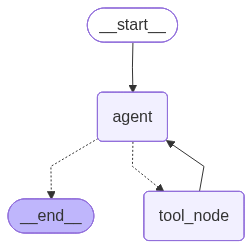

In [7]:
checkpointer = MemorySaver()
agent = graph_builder(checkpointer)
agent

### Memory Persistence in SQLite Memory

In [8]:
import sqlite3
import os

os.makedirs('db', exist_ok=True)

db_path = "db/checkpoint.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
checkpointer=SqliteSaver(conn)

In [9]:
def chat(agent, query, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    for chunk in agent.stream({"messages": [query]}, config=config):
        if 'agent' in chunk:
            chunk = chunk.get('agent')
        else:
            chunk = chunk.get('tools')
        if hasattr(chunk, "tool_calls") and chunk.tool_calls:
            for tc in chunk.tool_calls:
                print(f"[AGENT] called Tool: {tc.get('name', '?')} with args {tc.get('args', '?')}")
        else:
            print(f"[AGENT/TOOL] Responding...\n{chunk['messages'][0].content}")


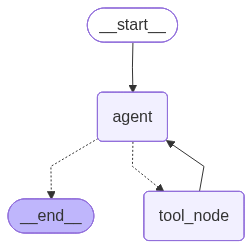

In [10]:
agent = graph_builder(checkpointer)
agent

In [11]:
query = "What is your name and what is 2+2?"
chat(agent, query, "thread_1")

[AGENT/TOOL] Responding...
What is your name and what is 2+2?


In [12]:
query = "What was my last question?"
chat(agent, query, "thread_1")

[AGENT/TOOL] Responding...
What is your name and what is 2+2?


In [13]:
query = "Who was Edwim M. Staton?"
chat(agent, query, "thread_2")

[AGENT/TOOL] Responding...
Who was Edwim M. Staton?


### Memory Persistence in PostgreSQL

In [ ]:
import psycopg
conn = psycopg.connect(os.getenv("POSTGRESQL_URL"), autocommit=True, prepare_threshold=0)
checkpointer = PostgresSaver(conn)

In [15]:
checkpointer.setup()

In [16]:
agent = graph_builder(checkpointer)
query = "What is 2+2? and which LLM Model are you?"
chat(agent, query, "thread_1")

[TOOL] calculate ('2+2') -> '4'
[AGENT/TOOL] Responding...
What is 2+2? and which LLM Model are you?
